# <center>Physionet/Cinc Challenge 2020 Plus Gradient Vizualization</center>
## This Notebook is a modified version of a notebook provided by [Bjoern Jostein](https://www.kaggle.com/bjoernjostein) [Physionet Challenge 2020](https://www.kaggle.com/bjoernjostein/physionet-challenge-2020). The [See RNN](https://github.com/OverLordGoldDragon/see-rnn) python package is used to vizualize the important parts of the ECG that influence the decision. It can be useful when you show the detection to an expert and would like to highlight the abnormal area. (It is not a complete explainability analysis but it can be considered as an early investigation.)

### Introduction
The electrocardiogram (ECG) reflects the electrical activity of the heart, and the interpretation of this recording can reveal numerous pathologies of the heart. An ECG is recorded using an electrocardiograph, where modern clinical devices usually contain automatic interpretation software that interprets the ECGs directly after recording. Although automatic ECG interpretation started in the 1950s, there are still some limitations. Because of the errors they make, doctors have to read over the ECGs . This is time consuming for the doctors and requires high degree of expertise. There is clearly a need for better ECG interpretation algorithms.

The recent years has shown a rapid improvement in the field of machine learning. A sub-field of machine learning is called Deep Learning, where more complex architectures of neural networks are better able to scale with the amount of data in terms of performance. This type of machine learning has shown promising performance in many fields including medicine, and in this study, we have explored the usefulness of deep learning in classifying 12-lead ECGs. 

As a starting point for our model architecture we chose to use the two best performing Convolutional Neural Networks (CNN) used on ECG data in [Fawaz HI et al 2019](https://link.springer.com/article/10.1007/s10618-019-00619-1?shared-article-renderer). They reported that Fully Convolutional Networks (FCN) outperformed eight other CNN architectures compared. We also wanted to test the second-best architecture which was an Encoder Network. We also assessed the integration of a rule-based algorithm within these models in order to test the performance of a CNN and rule-based hybrid classifier. 

This study is a part of the PhysioNet/Computing in Cardiology Challenge 2020, where the aim was to develop an automated interpretation algorithm for identification of clinical diagnoses from 12-lead ECG recordings.

In [38]:
!pip install ecg-plot
!pip install wfdb

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


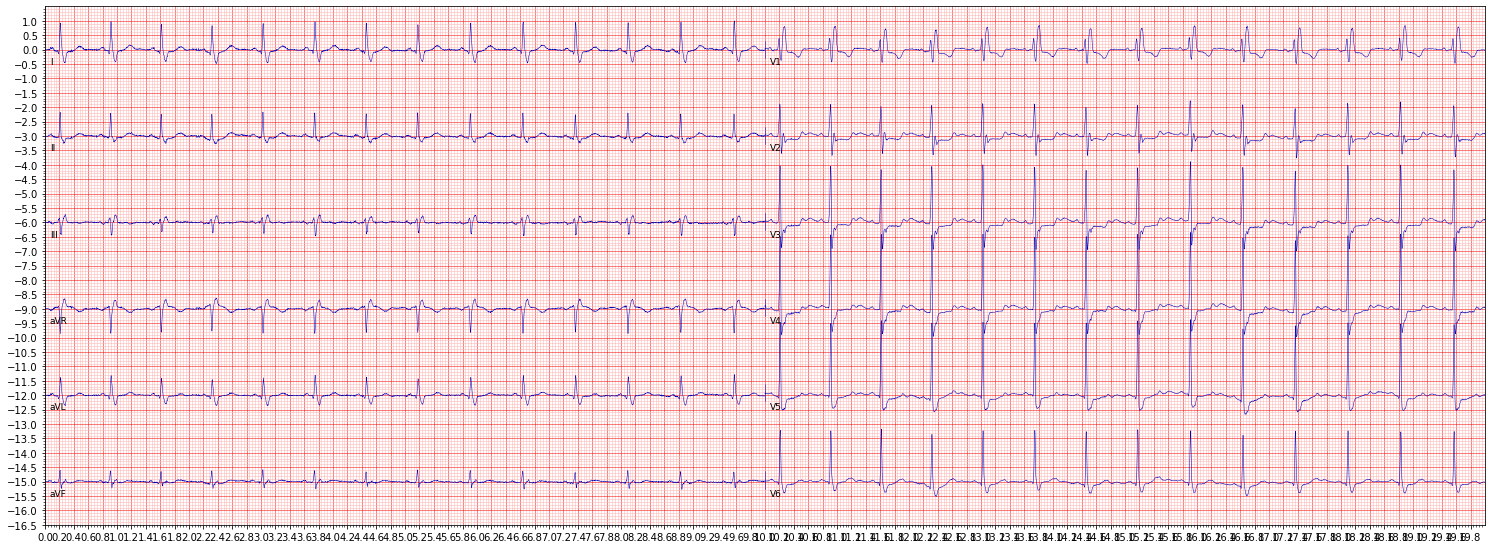

In [39]:
import physionet_challenge_utility_script as pc
import ecg_plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
%load_ext autoreload
%autoreload
%reload_ext autoreload

def plot_ecg(path):
    ecg_data = pc.load_challenge_data(path)
    ecg_plot.plot(ecg_data[0]/1000, sample_rate=500, title='')
    ecg_plot.show()
plot_ecg("/kaggle/input/china-12lead-ecg-challenge-database/Training_2/Q0948.mat")

In [40]:
ecg_data = pc.load_challenge_data("/kaggle/input/china-12lead-ecg-challenge-database/Training_2/Q0002.mat")
ecg_data[0].shape

(12, 7500)

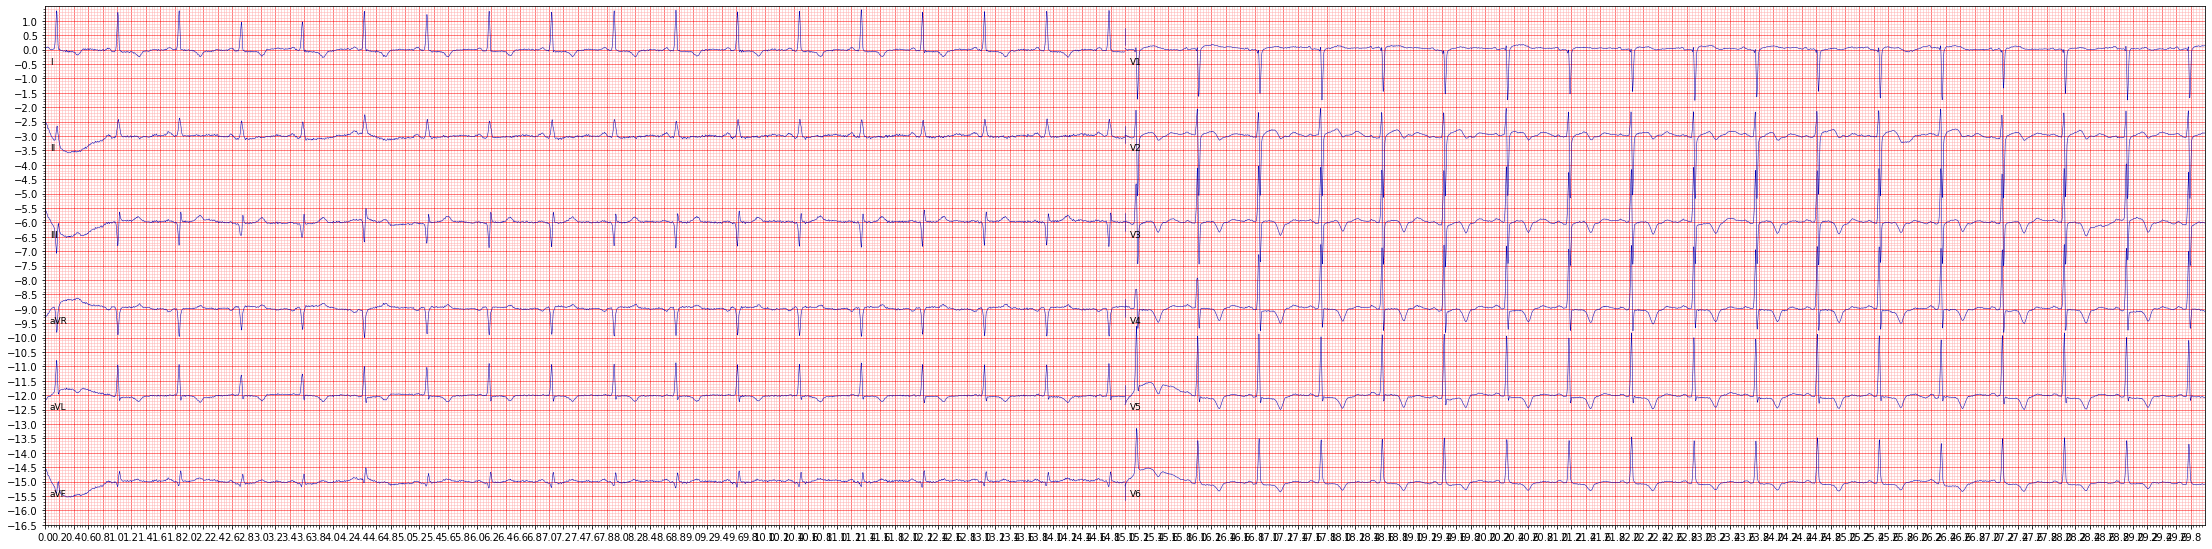

In [41]:
plot_ecg("/kaggle/input/china-12lead-ecg-challenge-database/Training_2/Q0002.mat")

### Methods


#### Data
The training data in this study contains 43.101 Electrocariographic recordings from 4 different sources. 
1. Southeast University, China, including the data from the China Physiological Signal Challenge 2018 (2 datasets from this source)
2. St. Petersburg Institute of Cardiological Technics, St. Petersburg, Russia.
3. The Physikalisch Technische Bundesanstalt, Brunswick, Germany. (2 datasets from this source)
4. Georgia 12-Lead ECG Challenge Database, Emory University, Atlanta, Georgia, USA.

The data is given in the form of native Python waveform-database-format [WFDB](https://wfdb.readthedocs.io/en/latest/). The dataset contains two file types:


1.   Header files (.hea)
2.   Signal files (.mat)

We have 43.101 Signal file with a corresponding header file. Each file are named with a patient number starting with ***A0001*** and goes all the way up to ***A6877***


In [42]:
gender, age, labels, ecg_filenames = pc.import_key_data("/kaggle/input/")
ecg_filenames = np.asarray(ecg_filenames)

#### From the figure under we can se that the signals varies, but most of the signals are around 5000 samples long

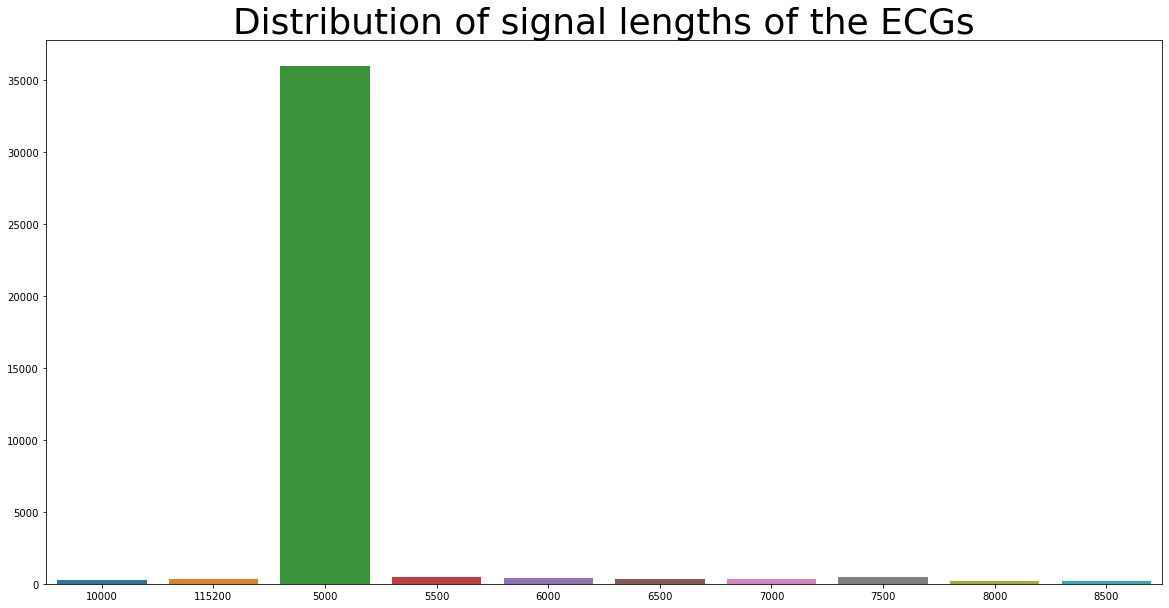

In [43]:
pc.get_signal_lengths("/kaggle/input/", "Distribution of signal lengths of the ECGs")

#### From the header file we have access to gender and age from each patient

In [44]:
age, gender = pc.import_gender_and_age(age, gender)

gender data shape: 43101
age data shape: 43101


#### All diagnoses are encoded with SNOMED-CT codes. We need a CSV-file to decode them:

In [45]:
SNOMED_scored=pd.read_csv("/kaggle/input/physionet-snomed-mappings/SNOMED_mappings_scored.csv", sep=";")
SNOMED_unscored=pd.read_csv("/kaggle/input/physionet-snomed-mappings/SNOMED_mappings_unscored.csv", sep=";")
df_labels = pc.make_undefined_class(labels,SNOMED_unscored)

#### To be able to feed the labels to a Neural Network we need to OneHot encode the labels

In [46]:
y , snomed_classes = pc.onehot_encode(df_labels)

The classes we will look at are encoded as SNOMED CT codes:
['10370003' '111975006' '164889003' '164890007' '164909002' '164917005'
 '164934002' '164947007' '17338001' '251146004' '270492004' '284470004'
 '39732003' '426177001' '426627000' '426783006' '427084000' '427172004'
 '427393009' '445118002' '47665007' '59118001' '59931005' '63593006'
 '698252002' '713426002' '713427006' 'undefined class']
classes: 27


In [47]:
snomed_abbr = []
for j in range(len(snomed_classes)):
    for i in range(len(SNOMED_scored.iloc[:,1])):
        if (str(SNOMED_scored.iloc[:,1][i]) == snomed_classes[j]):
            snomed_abbr.append(SNOMED_scored.iloc[:,2][i])
            
snomed_abbr = np.asarray(snomed_abbr)

#### The distribution of diagnoses accross the dataset
In the figure under we can see the same SNOMED CT codes decoded into human readable diagnoses on the X-axis. On the Y-axis we have the number of the given diagnoses in the dataset

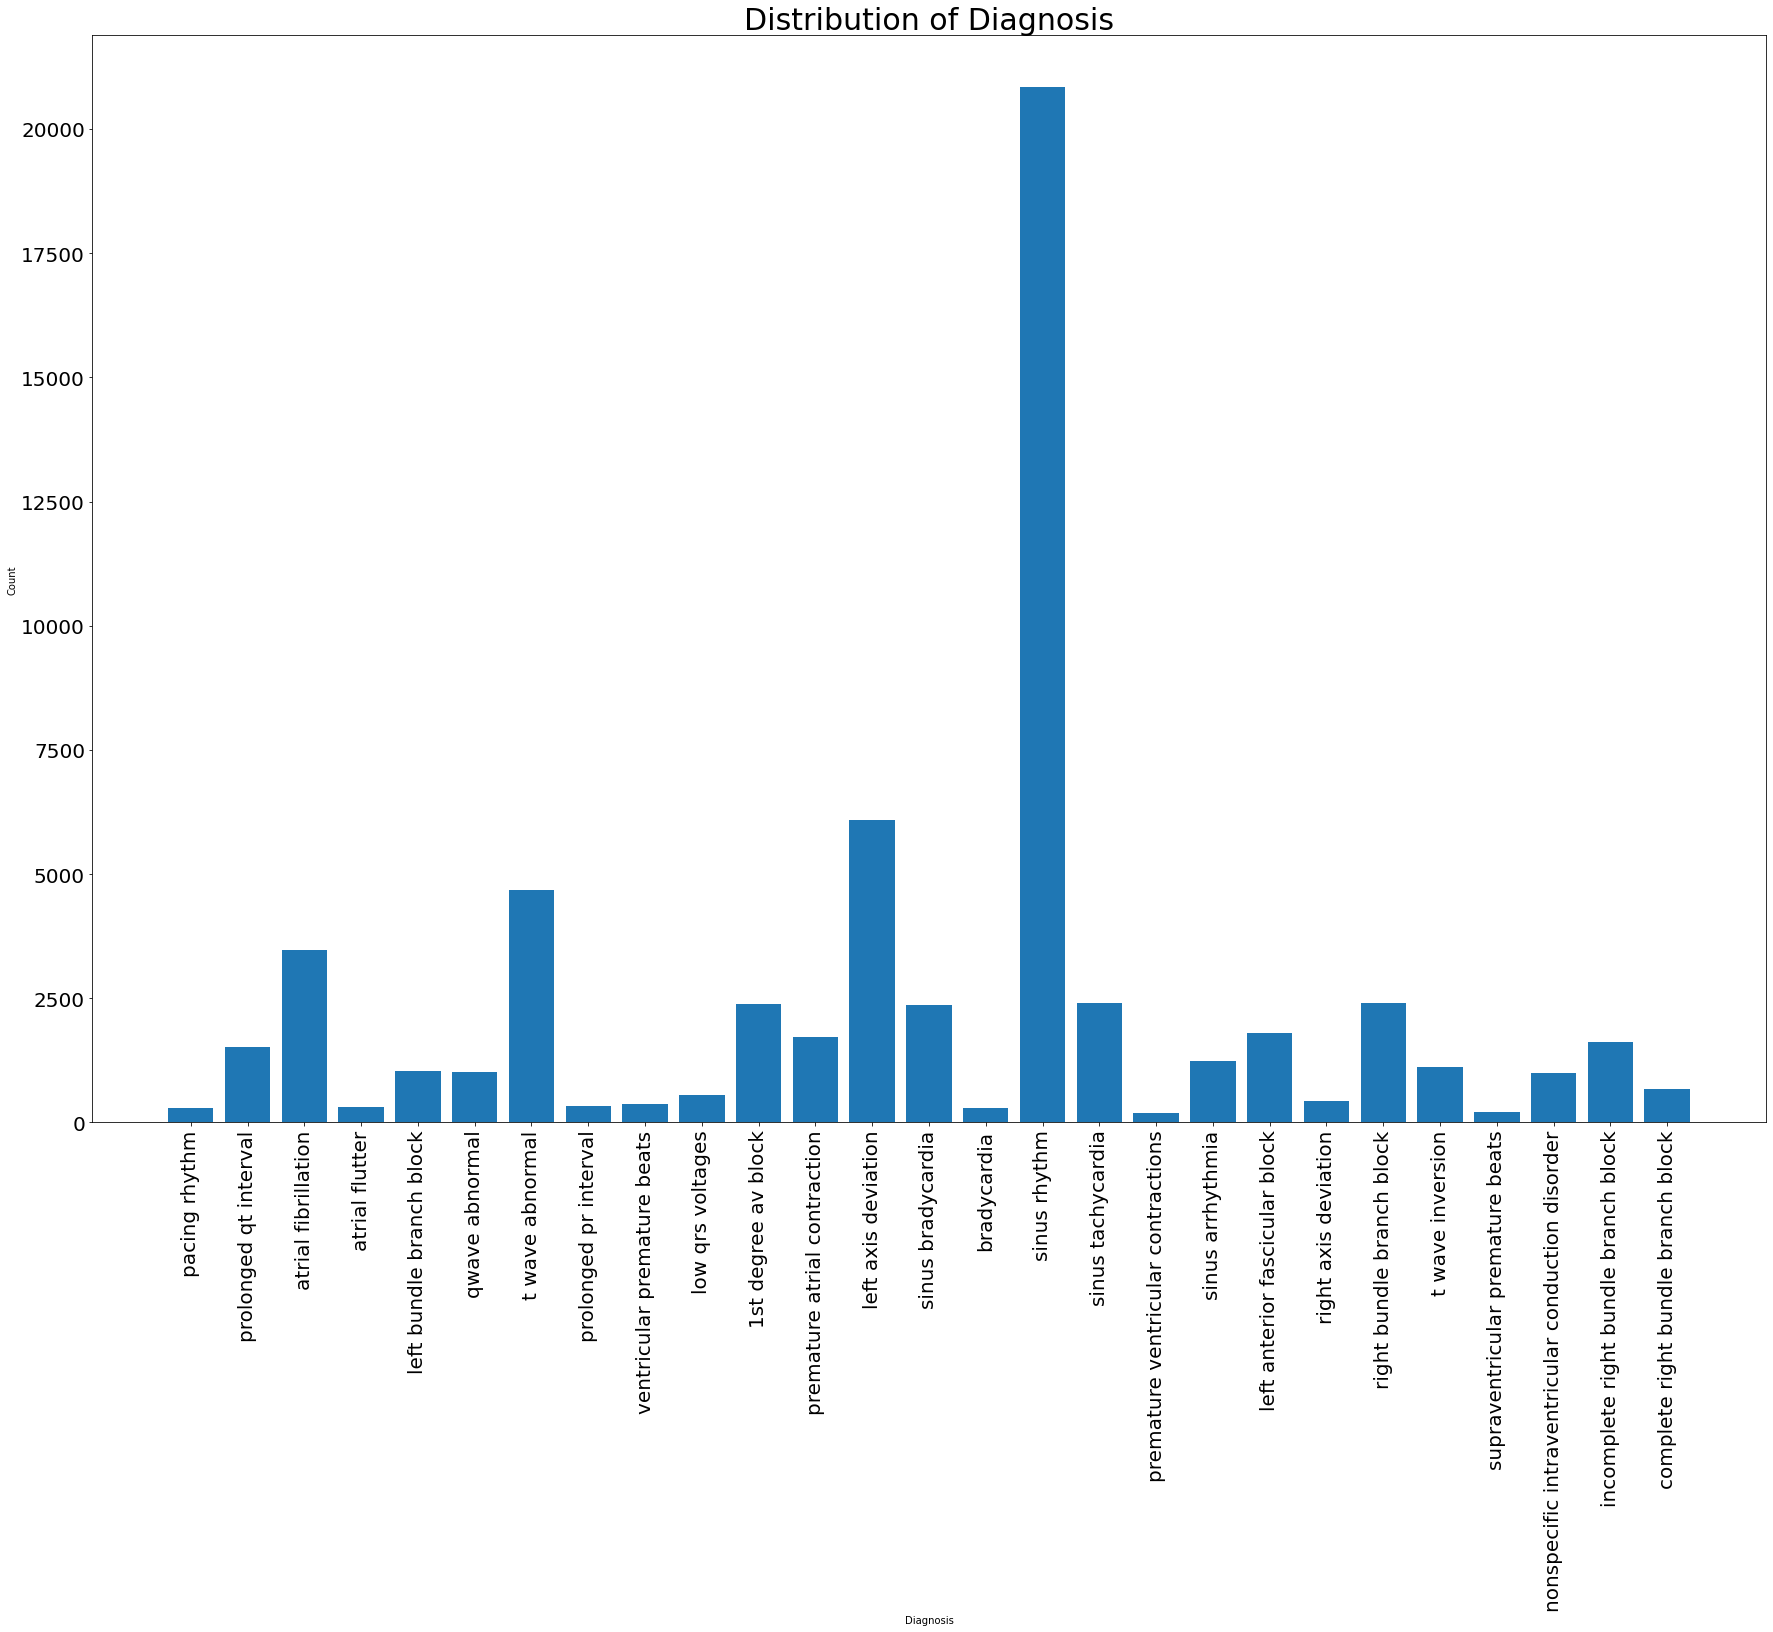

In [48]:
pc.plot_classes(snomed_classes, SNOMED_scored,y)

#### Since this is a multiclass multi-label classification there will be a lot of different combinations of the 27 diagnoses in this study

In [49]:
y_all_comb = pc.get_labels_for_all_combinations(y)
print("Total number of unique combinations of diagnosis: {}".format(len(np.unique(y_all_comb))))

Total number of unique combinations of diagnosis: 1414


#### We will split the data using a 10-fold split with Shuffle=True and random_seed = 42. 
The distribution of Training and Val data in each fold is now:
(in this study we only use the first fold for hold out validation)

In [50]:
folds = pc.split_data(labels, y_all_comb)

Training split: 38790
Validation split: 4311


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


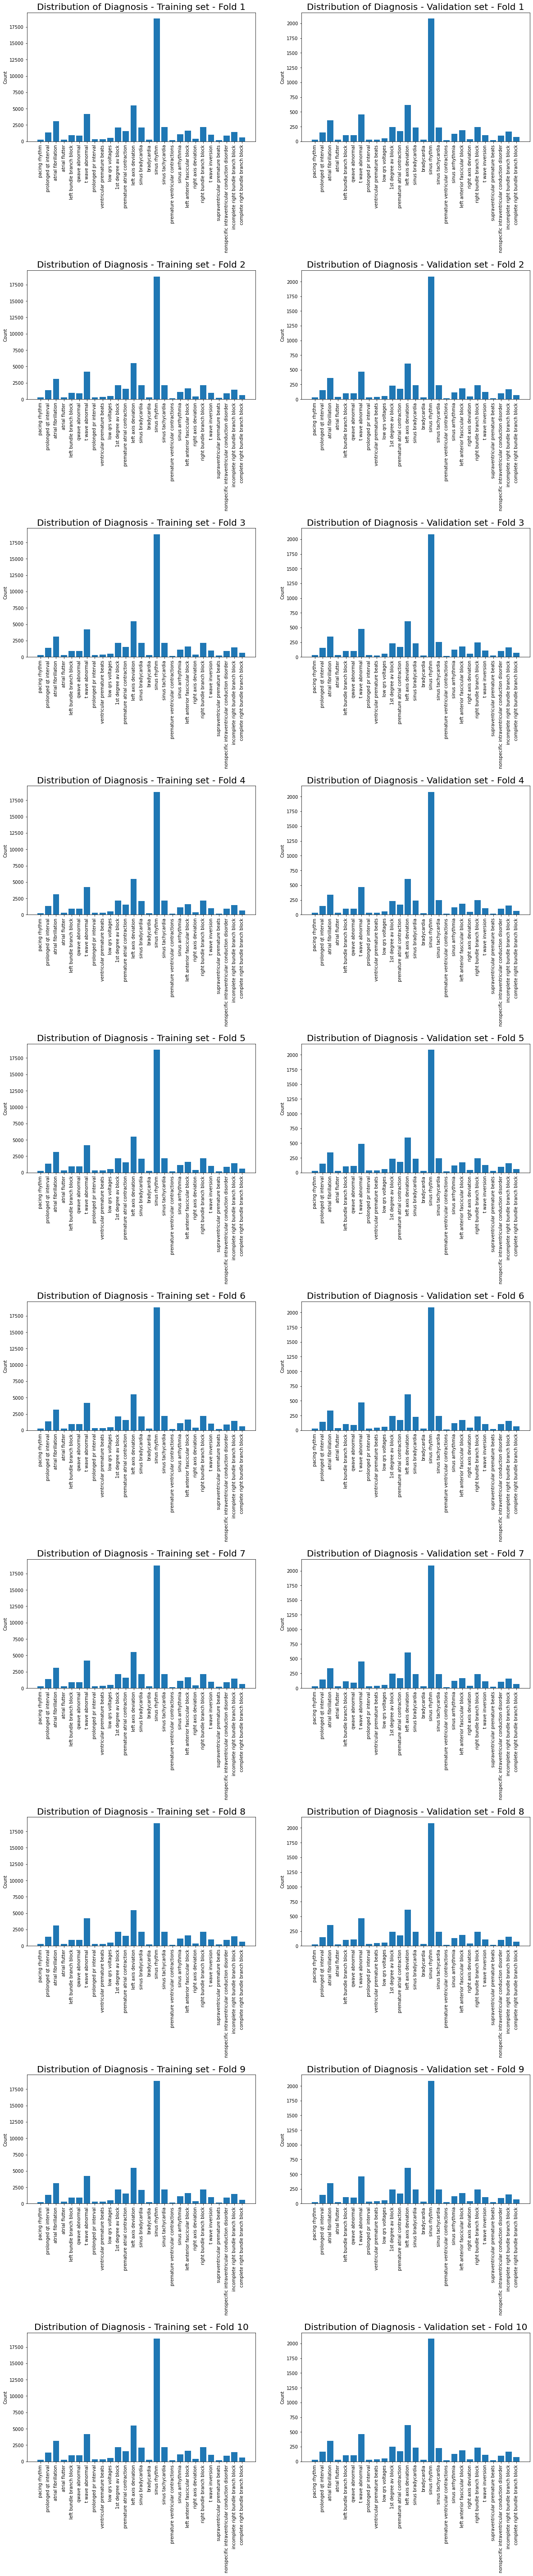

In [51]:
pc.plot_all_folds(folds,y,snomed_classes)

#### Make Batch generators
To feed the Neural Network with a dataset that is too large for our RAM set we need a batch generator to get data into the RAM in batches.
We start by making a "order array" so we can shuffle the order of the data during the training process

In [52]:
order_array = folds[0][0]

In [53]:
def shuffle_batch_generator_demo(batch_size, gen_x,gen_y, gen_z): 
    np.random.shuffle(order_array)
    batch_features = np.zeros((batch_size,5000, 12))
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0])) #drop undef class
    batch_demo_data = np.zeros((batch_size,2))
    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)
            batch_demo_data[i] = next(gen_z)

        X_combined = [batch_features, batch_demo_data]
        yield X_combined, batch_labels
        
def shuffle_batch_generator(batch_size, gen_x,gen_y): 
    np.random.shuffle(order_array)
    batch_features = np.zeros((batch_size,5000, 12))
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0])) #drop undef class
    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)
            
        yield batch_features, batch_labels

def generate_y_shuffle(y_train):
    while True:
        for i in order_array:
            y_shuffled = y_train[i]
            yield y_shuffled


def generate_X_shuffle(X_train):
    while True:
        for i in order_array:
                #if filepath.endswith(".mat"):
                    data, header_data = pc.load_challenge_data(X_train[i])
                    X_train_new = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
                    X_train_new = X_train_new.reshape(5000,12)
                    yield X_train_new

def generate_z_shuffle(age_train, gender_train):
    while True:
        for i in order_array:
            gen_age = age_train[i]
            gen_gender = gender_train[i]
            z_train = [gen_age , gen_gender]
            yield z_train

#### Imbalanced data
To compensate for the imbalaced data we calculate a weight for each label. The weight decides how much the Neural Network will learn from the different data labels

In [54]:
new_weights=pc.calculating_class_weights(y)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0.0, 1.0], y=[0 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0.0, 1.0], y=[0 0 0 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0.0, 1.0], y=[0 0 0 ... 0 1 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [55]:
keys = np.arange(0,27,1)
weight_dictionary = dict(zip(keys, new_weights.T[1]))
weight_dictionary

{0: 72.0752508361204,
 1: 14.243555849306015,
 2: 6.201582733812949,
 3: 68.63216560509554,
 4: 20.701729106628243,
 5: 21.273938795656466,
 6: 4.611705542478066,
 7: 63.383823529411764,
 8: 59.04246575342466,
 9: 38.759892086330936,
 10: 9.00187969924812,
 11: 12.464141122035858,
 12: 3.5409957279000985,
 13: 9.13543874523103,
 14: 74.828125,
 15: 1.0337954523649622,
 16: 8.971898417985013,
 17: 114.63031914893617,
 18: 17.379435483870967,
 19: 11.932724252491694,
 20: 50.469555035128806,
 21: 8.971898417985013,
 22: 19.379946043165468,
 23: 100.23488372093023,
 24: 21.615346038114343,
 25: 13.37709497206704,
 26: 31.552708638360176}

#### Learning rate reduction
To controll the learning rate we use learning rate reduction and early stopping to prevent overfitting

In [56]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_AUC', factor=0.1, patience=1, verbose=1, mode='max',
    min_delta=0.0001, cooldown=0, min_lr=0
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', mode='max', verbose=1, patience=2)

#### To find the optimal threshold we will use Downhill simplex method

In [57]:
from scipy import optimize
def thr_chall_metrics(thr, label, output_prob):
    return -pc.compute_challenge_metric_for_opt(label, np.array(output_prob>thr))

### Results

#### Residual Neural Network

In [58]:
model = pc.residual_network_1d()

load a pre-trained model

In [59]:
model.load_weights("/kaggle/input/physionet-challenge-models/resnet_model.h5")

##### or train it your self by uncomment the code below

In [60]:
#batchsize = 30
#model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), gen_y=generate_y_shuffle(y)), epochs=100, steps_per_epoch=(len(order_array)/batchsize), validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]), validation_freq=1, class_weight=weight_dictionary, callbacks=[reduce_lr,early_stop])

In [61]:
y_pred = model.predict(x=pc.generate_validation_data(ecg_filenames,y,folds[0][1])[0])

In [62]:
init_thresholds = np.arange(0,1,0.05)

In [63]:
all_scores = pc.iterate_threshold(y_pred, ecg_filenames, y ,folds[0][1] )

0.1534810096885334
0.3297317699365682
0.342811213382519
0.2848491693585519
0.18583020359201716
0.07314262445007357
-0.03356212057784509
-0.1368148426982439
-0.2381345490936135
-0.32221178775038695
-0.4053670014896015
-0.48094856691146654
-0.5496682111352696
-0.6165902401886156
-0.6683165049012421
-0.7122407700909712
-0.7478531489847304
-0.7759416484136316
-0.7990028431676786
-0.815278559078797


In [64]:
new_best_thr = optimize.fmin(thr_chall_metrics, args=(pc.generate_validation_data(ecg_filenames,y,folds[0][1])[1],y_pred), x0=init_thresholds[all_scores.argmax()]*np.ones(27))

Optimization terminated successfully.
         Current function value: -0.381719
         Iterations: 377
         Function evaluations: 682


In [65]:
print(pc.compute_challenge_metric_for_opt(pc.generate_validation_data(ecg_filenames,y,folds[0][1])[1],(y_pred>new_best_thr)*1))

0.3817191987902541


Make conf.matrix

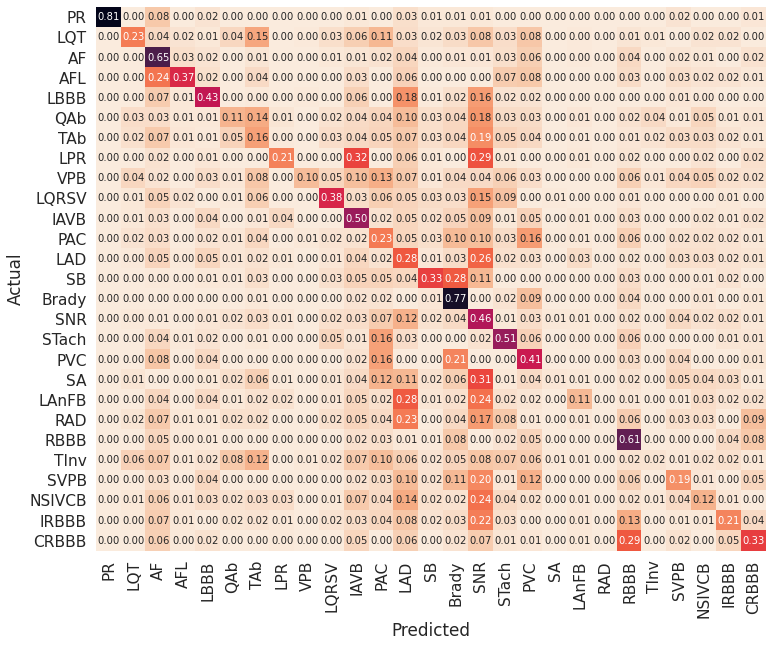

In [66]:
pc.plot_normalized_conf_matrix(y_pred, ecg_filenames, y, folds[0][1], new_best_thr, snomed_classes, snomed_abbr)
plt.savefig("confusion_matrix_resnet.png", dpi=100)

In [67]:
test_aa = pc.generate_validation_data(ecg_filenames,y,folds[0][1])[0]
print(test_aa.shape)

(4311, 5000, 12)


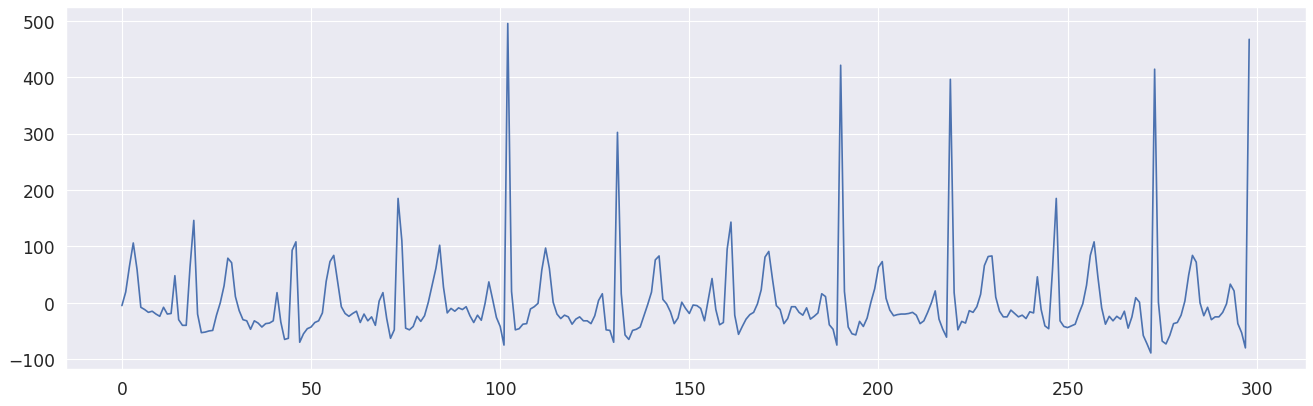

In [68]:
from matplotlib.pyplot import figure

figure(figsize=(20, 6), dpi=80)

plt.plot(test_aa[0,1:300,1])

In [69]:
y_pred.shape

(4311, 27)

In [70]:
test_aa[:2,:,:].shape

(2, 5000, 12)

In [71]:
!git clone https://github.com/OverLordGoldDragon/see-rnn.git
    
import sys

sys.path.insert(1, '/kaggle/working/see-rnn')

Cloning into 'see-rnn'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 408 (delta 39), reused 52 (delta 25), pack-reused 331 (from 1)
Receiving objects: 100% (408/408), 218.84 KiB | 1.56 MiB/s, done.
Resolving deltas: 100% (260/260), done.


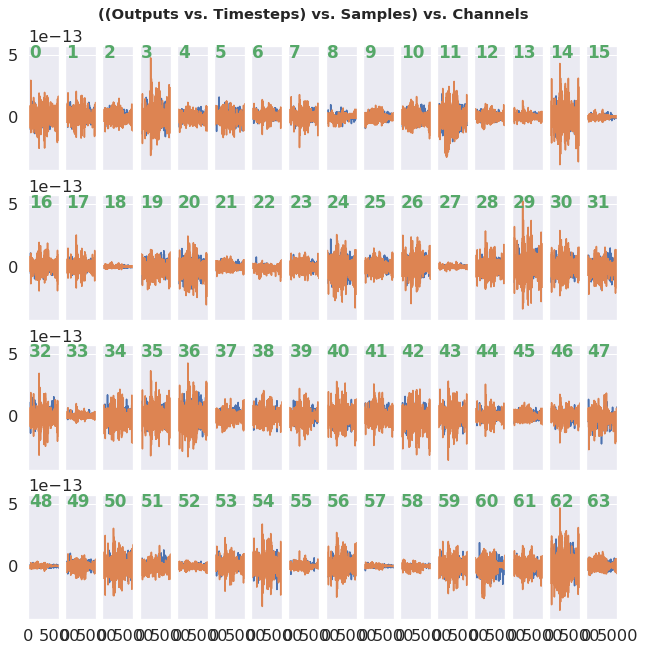

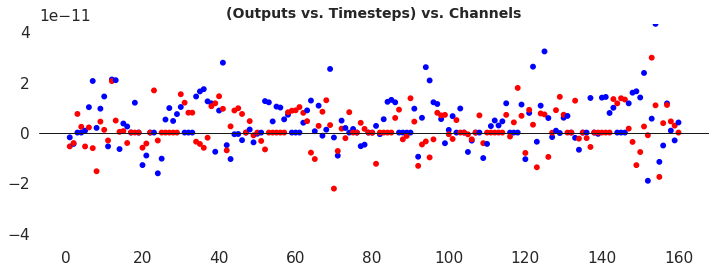

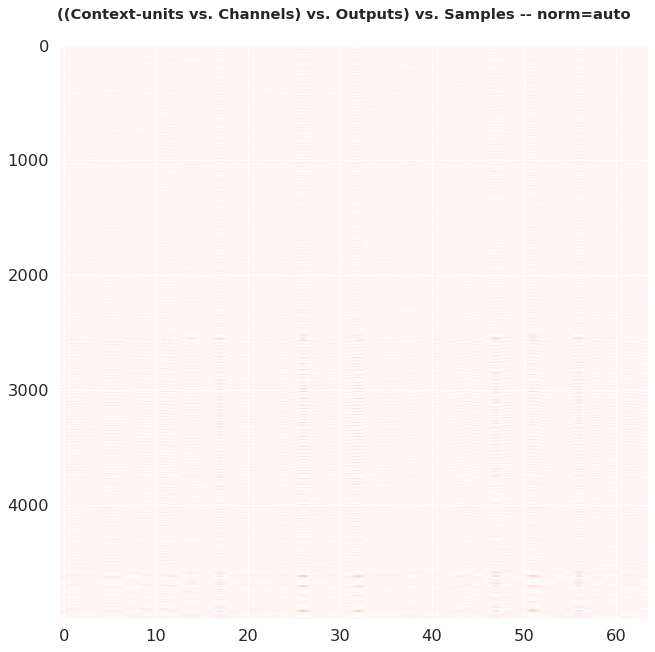

(<Figure size 760x760 with 1 Axes>,
 array(<matplotlib.axes._subplots.AxesSubplot object at 0x7c2b1177f1d0>,
       dtype=object))

In [72]:
x = test_aa[:2,:,:]
y = y_pred[:2,:]

from see_rnn import get_gradients, get_outputs, features_0D, features_1D, features_2D
grads_all  = get_gradients(model, 1, x, y)  # return_sequences=True,  layer index 1
grads_last = get_gradients(model, 2, x, y)  # return_sequences=False, layer index 2

outs  = get_outputs(model, 1, x) 

features_1D(grads_all, n_rows=4)
# features_2D(grads_all, n_rows=16, norm=(-.01, .01))

features_0D(grads_last[1,0:160,:2])

features_2D(outs[0])

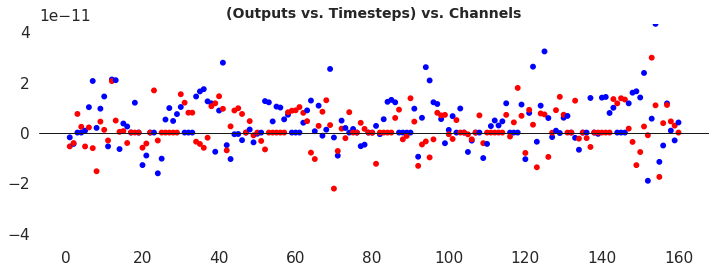

(<Figure size 864x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7c2b117272d0>)

In [73]:
features_0D(grads_last[1,0:160,:2])

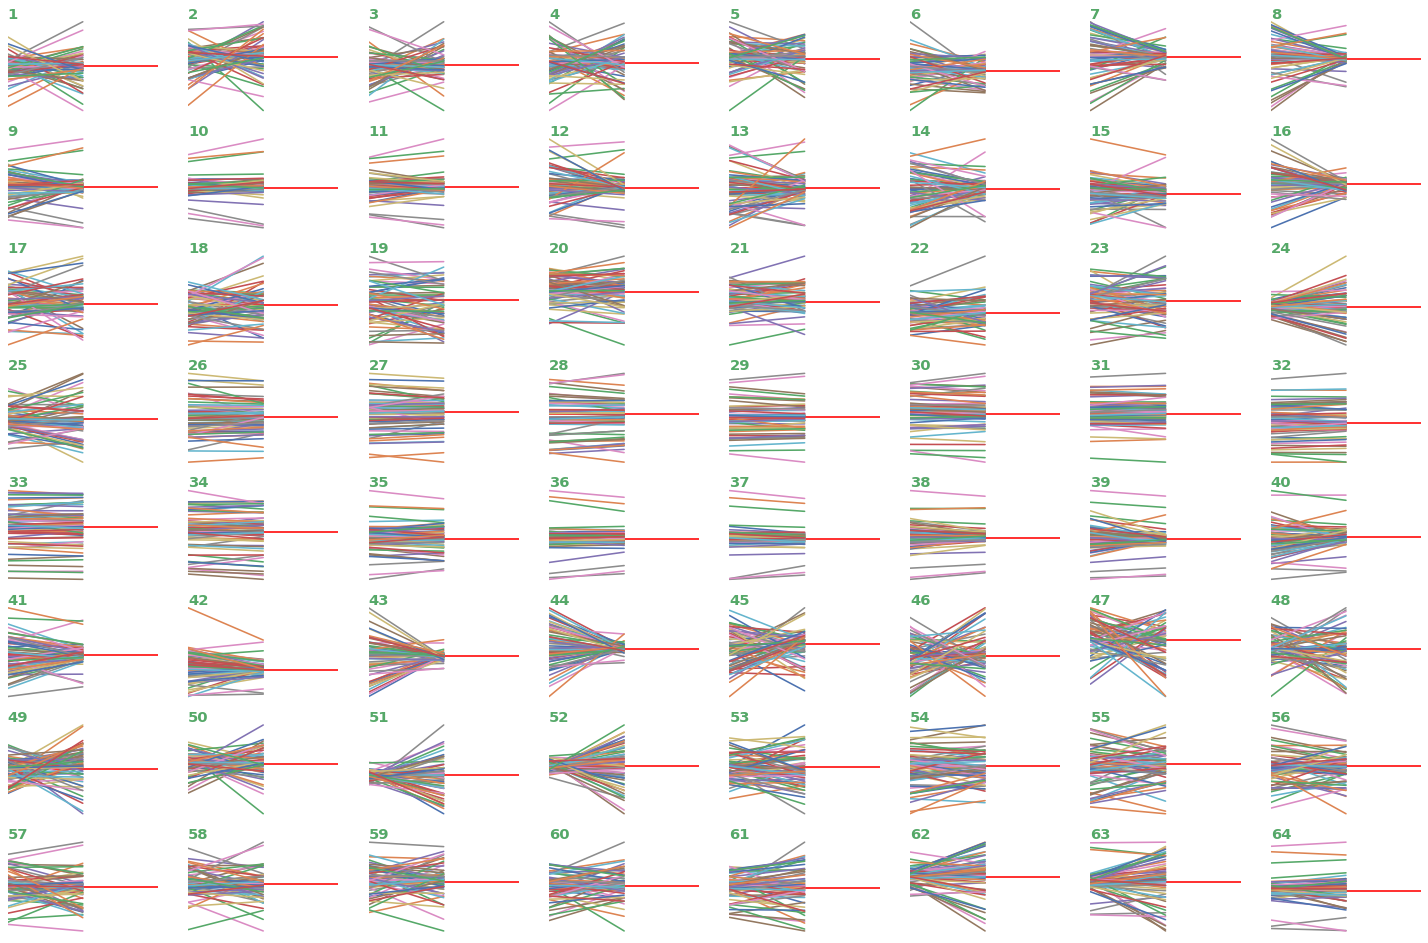

In [74]:
# https://stackoverflow.com/questions/58356868/how-visualize-attention-lstm-using-keras-self-attention-package
def show_features_1D_nv(model=None, layer_name=None, input_data=None,
                     prefetched_outputs=None, max_timesteps=100,
                     max_col_subplots=10, equate_axes=False,
                     show_y_zero=True, channel_axis=-1,
                     scale_width=1, scale_height=1, dpi=76):
    if prefetched_outputs is None:
        layer_outputs = get_layer_outputs(model, layer_name, input_data, 1)[0]
    else:
        layer_outputs = prefetched_outputs
    n_features    = layer_outputs.shape[channel_axis]

    for _int in range(1, max_col_subplots+1):
          if (n_features/_int).is_integer():
                n_cols = int(n_features/_int)
    n_rows = int(n_features/n_cols)

    fig, axes = plt.subplots(n_rows,n_cols,sharey=equate_axes,dpi=dpi)
    fig.set_size_inches(24*scale_width,16*scale_height)

    subplot_idx = 0
    for row_idx in range(axes.shape[0]):
        for col_idx in range(axes.shape[1]): 
            subplot_idx += 1
            feature_output = layer_outputs[:,subplot_idx-1]
            feature_output = feature_output[:max_timesteps]
            ax = axes[row_idx,col_idx]

            if show_y_zero:
                ax.axhline(0,color='red')
            ax.plot(feature_output)

            ax.axis(xmin=0,xmax=len(feature_output))
            ax.axis('off')

            ax.annotate(str(subplot_idx),xy=(0,.99),xycoords='axes fraction',
                        weight='bold',fontsize=14,color='g')
    if equate_axes:
        y_new = []
        for row_axis in axes:
            y_new += [np.max(np.abs([col_axis.get_ylim() for 
                                     col_axis in row_axis]))]
        y_new = np.max(y_new)
        for row_axis in axes:
            [col_axis.set_ylim(-y_new,y_new) for col_axis in row_axis]
    plt.show()

show_features_1D_nv(grads_all, prefetched_outputs = outs)

(2, 5000, 64)


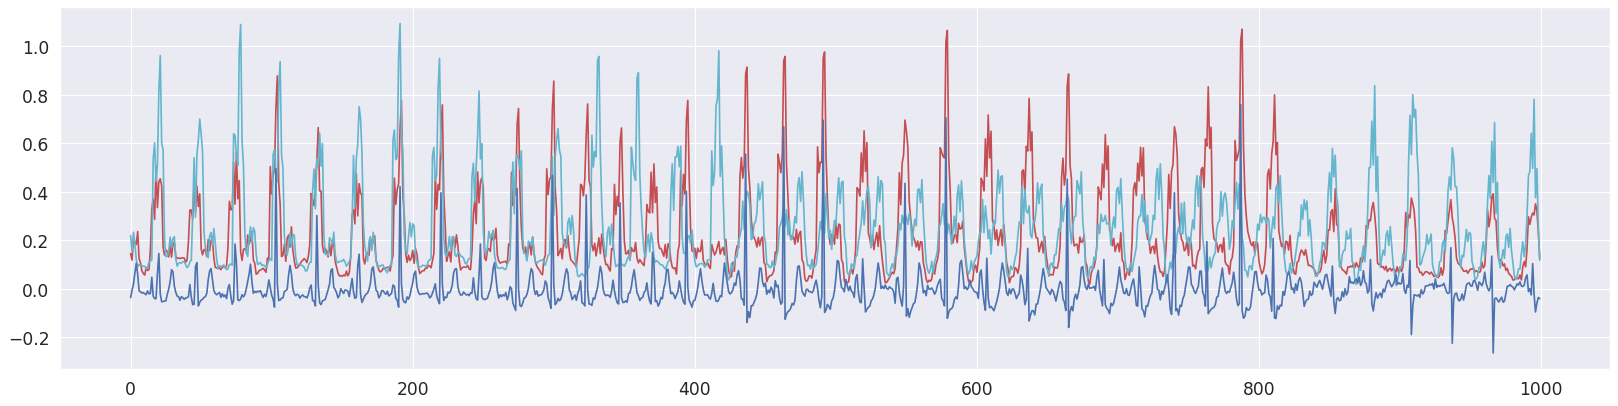

In [75]:
print(grads_all.shape)
end_time = 1000
figure(figsize=(25, 6), dpi=80)
# plt.plot(test_aa[0,1:1000,1]/1000)
plt.plot(pd.DataFrame(outs[0]).max(axis= 1).values[:end_time]/2000,'r')
plt.plot(pd.DataFrame(outs[1]).max(axis= 1).values[:end_time]/2000,'c')
plt.plot(test_aa[0,:end_time,1]/1000)
plt.show()

In [76]:
grads_all.shape

(2, 5000, 64)

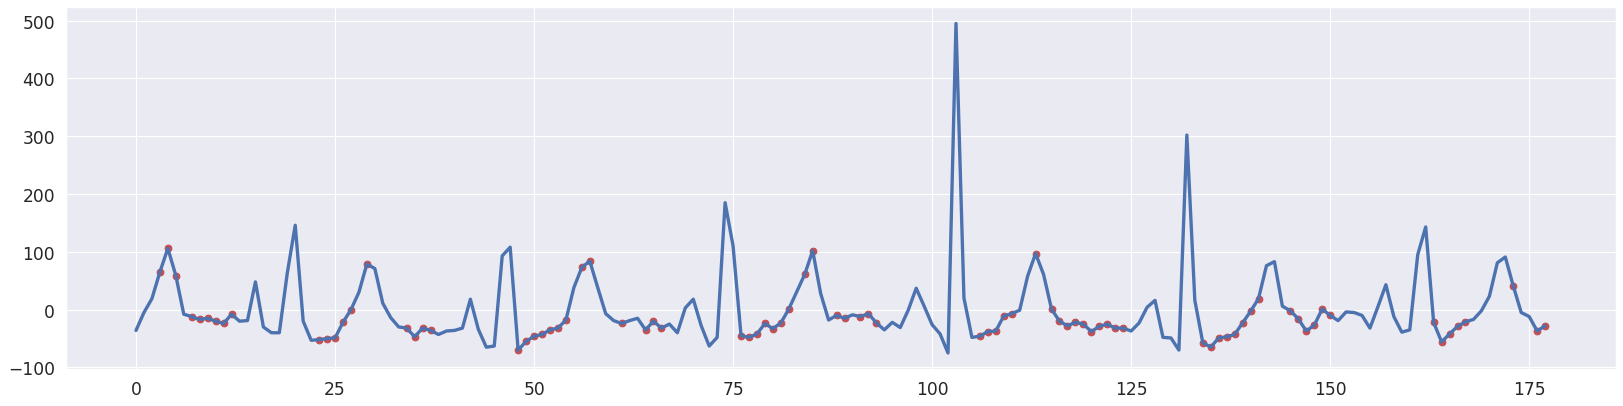

In [77]:
end_time = int(5000/28)
thresh = 0.2
x_range = range(end_time)
# gradient_1 = pd.DataFrame(grads_all[0,:,:]).abs().max(axis= 1).values[:end_time]*10**13
gradient_1 = pd.DataFrame(grads_last[0,:,:]).abs().max(axis= 1).values[:end_time]*10**10
gradient_12 = []
for ii in range(end_time):
    if gradient_1[ii] >= thresh:
           gradient_12.append(test_aa[0,ii,1])
    else:
        gradient_12.append(0)

figure(figsize=(25, 6), dpi=80)
# plt.plot(test_aa[0,1:1000,1]/1000)
# plt.plot(gradient_12,'r',linewidth=5.0)
# plt.plot(np.array(np.where(gradient_1 >=0.2)).reshape(-1,1), gradient_1[np.where(gradient_1 >= 0.2)],'r',linewidth=5.0)
# plt.scatter(np.array(np.where(gradient_1 >=thresh)).reshape(-1,1), gradient_1[np.where(gradient_1 >= thresh)], c='r')
plt.scatter(np.array(np.where(gradient_1 >=thresh)).reshape(-1,1), pd.DataFrame(gradient_12).iloc[np.where(gradient_1 >= thresh)], c='r')
plt.plot(test_aa[0,:end_time,1],linewidth=3)
plt.show()

In [78]:
pd.DataFrame(grads_all[0,:,:]).abs().max(axis= 1).values[:end_time]*10**13

array([0.22526626, 0.39249054, 0.19700518, 0.31695156, 0.37182151,
       0.34896785, 0.44833833, 0.49334811, 0.50941591, 0.64059381,
       0.54045452, 0.41353344, 0.47462471, 0.38810423, 0.30081186,
       0.11318666, 0.15101842, 0.09035186, 0.17322451, 0.2709821 ,
       0.27104902, 0.28590753, 0.1649886 , 0.64690203, 0.90883288,
       0.65964575, 0.52469392, 0.45893577, 0.30045943, 0.35199271,
       0.41962951, 0.35084196, 0.21844532, 0.25269822, 0.49716955,
       0.41602172, 0.55873895, 0.49205387, 0.35483061, 0.27020754,
       0.2023424 , 0.1737362 , 0.17895108, 0.22234137, 0.2680308 ,
       0.3420442 , 0.23342222, 0.33771031, 0.41317647, 0.46790479,
       1.09968749, 1.21496373, 0.56653179, 0.55814718, 0.44866932,
       0.47389135, 0.50512034, 0.55453363, 0.36076472, 0.27031091,
       0.36929305, 0.37133504, 0.40338243, 0.28971102, 0.4802996 ,
       0.40856373, 0.26080995, 0.2020858 , 0.24969269, 0.16731142,
       0.14834681, 0.18808868, 0.22230566, 0.29863068, 0.27792

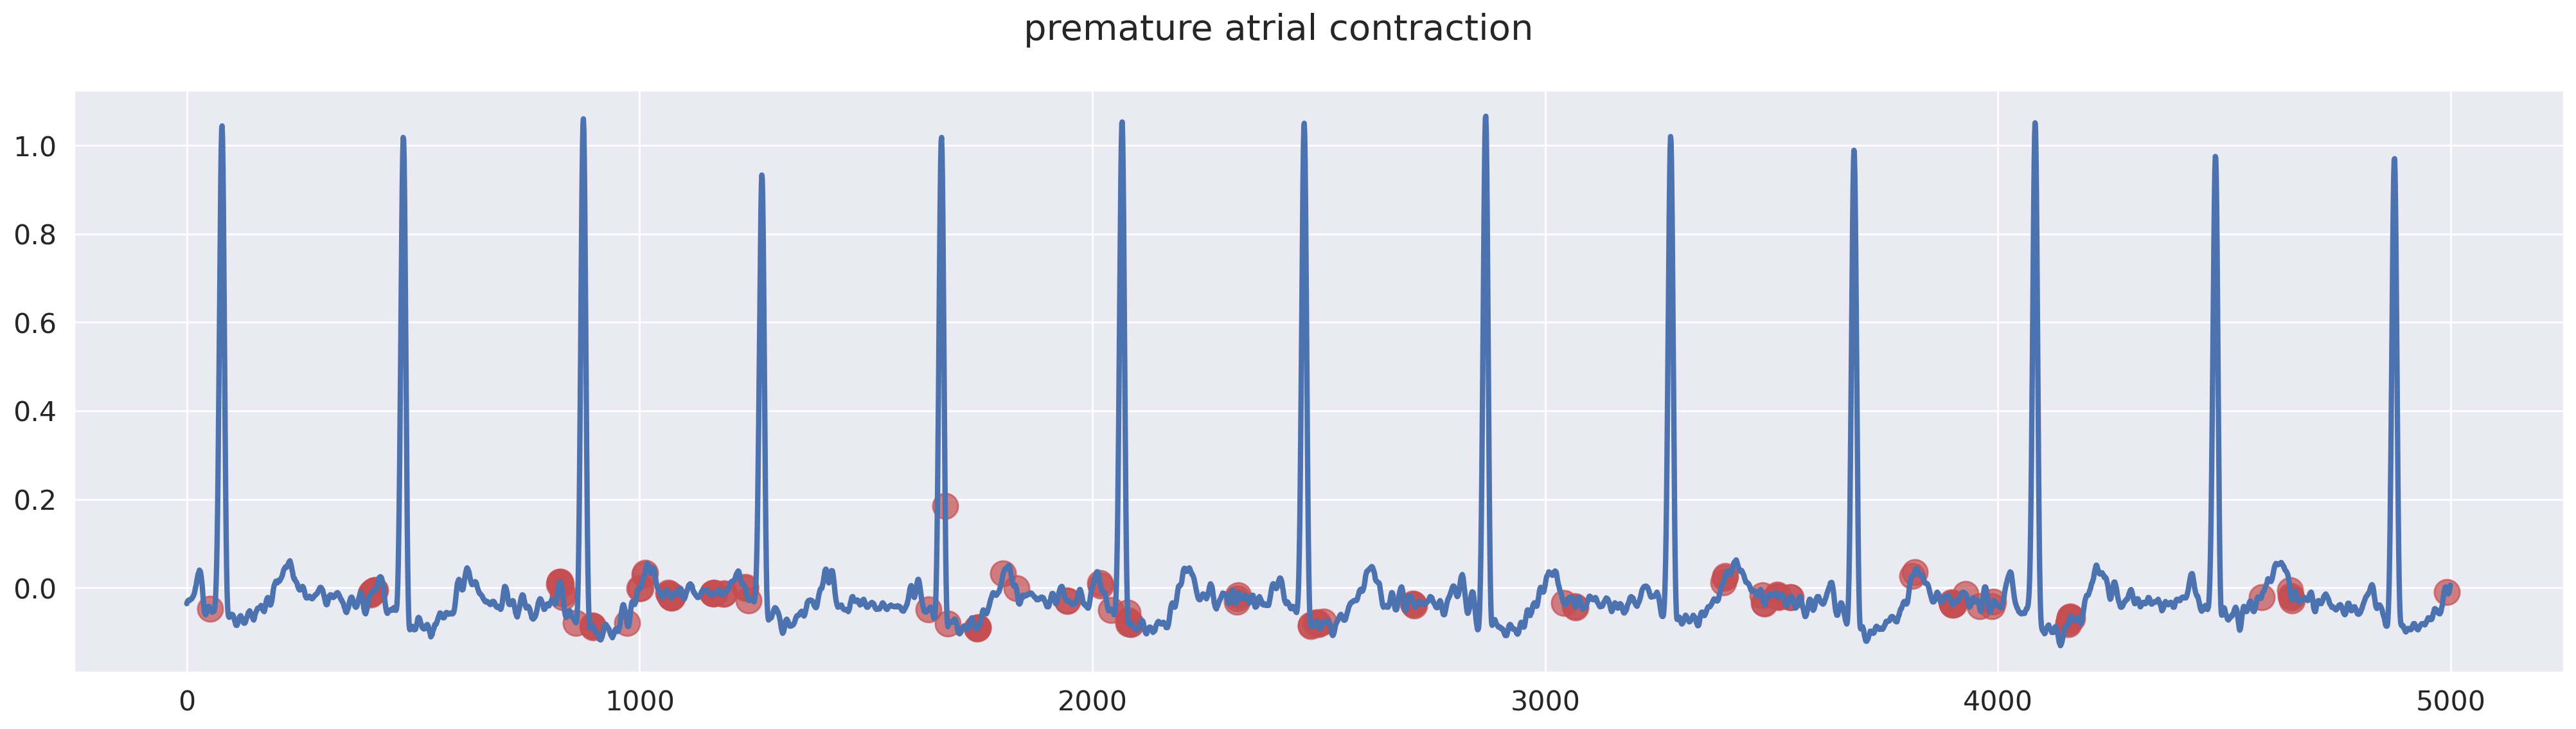

In [79]:
ecg_data = pc.load_challenge_data(ecg_filenames[0])
ecg_data2 = np.array(ecg_data)

end_time = 5000
thresh = 1.2
x_range = range(end_time)
gradient_1 = pd.DataFrame(grads_all[0,:,:]).abs().max(axis= 1).values[:end_time]*10**13
gradient_12 = []
for ii in range(end_time):
    if gradient_1[ii] >= thresh:
           gradient_12.append(ecg_data2[0][0,ii]/1000)
    else:
        gradient_12.append(0)

fig, ax = plt.subplots(figsize=(25, 6), dpi=200)

fig.suptitle(snomed_classes[np.argmax(y_pred[0])])

ax.scatter(np.array(np.where(gradient_1 >=thresh)).reshape(-1,1), pd.DataFrame(gradient_12).iloc[np.where(gradient_1 >= thresh)], c='r', s = 200, alpha= 0.7)
step = 1.0/500
# plt.scatter(np.arange(0, len(np.array(np.where(gradient_1 >=thresh)).reshape(-1,1))*step, step), pd.DataFrame(gradient_12).iloc[np.where(gradient_1 >= thresh)], c='r')
plt.plot(ecg_data2[0][0, :end_time]/1000,linewidth=3)

# ax.plot(np.arange(0, len(ecg_data2[0][0, :end_time])*step, step), ecg_data2[0][0, :end_time],  linewidth=2.0, color='b')
plt.show()

(12, 5500)


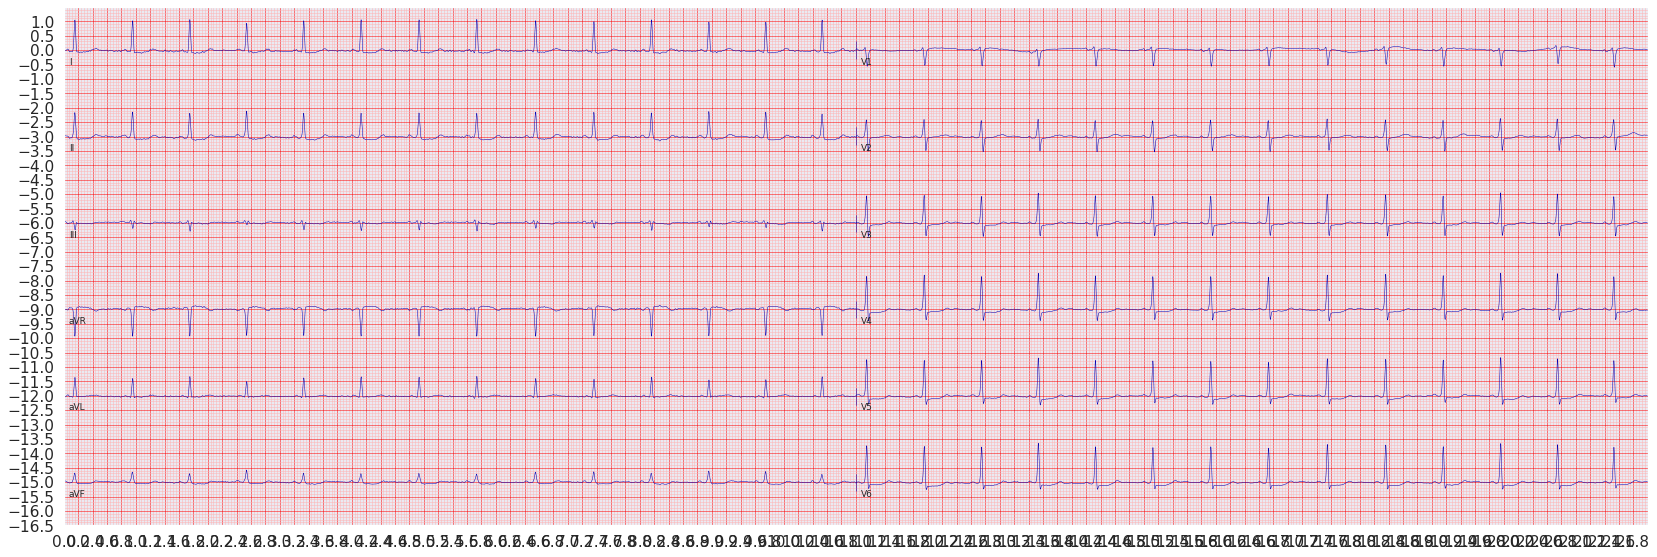

In [80]:
print(ecg_data2[0].shape)
ecg_plot.plot(ecg_data2[0]/1000, sample_rate=500, title='')
ecg_plot.show()